<a href="https://www.nvidia.com/dli"> <img src="images/combined_logo.png" alt="Header" style="width: 400px;"/> </a>

# Disaster Risk Monitoring Using Satellite Imagery #

## 03 - Deploying a Model for Inference ##
In this notebook, you will take the previously trained segmentation model and deploy it with Triton Inference Server. You'll learn how to create the model directory structures and configuration files within Triton Inference Server as well as how to send inference requests. 

**Table of Contents**
<br>
This notebook covers the below sections: 
1. [Model Deployment](#s3-1)
2. [Introduction to Triton Inference Server](#s3-2)
    * [Server](#s3-2.1)
    * [Client](#s3-2.2)
3. [Model Repository](#s3-3)
    * [Exercise #1 - Model Configuration](#s3-e1)
4. [Run Inference on Triton Inference Server](#s3-4)
    * [Server Health Status](#s3-4.1)
    * [Exercise #2 - Pre-Process Inputs](#s3-e2)
    * [Send Inference Request to Server](#s3-4.2)
    * [Visualize Results](#s3-4.3)
    * [Run Batch Inference](#s3-4.4)
5. [Inference Performance Optimization](#s3-5)

<a name='s3-1'></a>
## Model Deployment ##
Model deployment refers to the integration of deep learning inference into an existing system or process. Sometimes it's advantageous to keep the deep learning model isolated, and other times, it needs to be more available for broad use. We imagine our flood detection model to have more utility if it can produce real-time inference, therefore we employ a solution to allow for its use via network APIs. While model training focuses on accuracy as the key metric, model deployment concentrates on inference performance metrics such as [throughput](https://en.wikipedia.org/wiki/Network_throughput), [latency](https://en.wikipedia.org/wiki/Latency_(engineering)), and hardware utilization. 

Model deployment considerations: 
* **Throughput**: the amount of data that are processed in a specific amount of time
* **Latency**: the amount of time it takes for the input to be processed is critical for real-time inference
* **Hardware Utilization**: how much of the hardware is being utilized/unutilized
* **Deployment Environment**: environments can vary depending on the application - public cloud, on-premises core (data center), enterprise edge, and on embedded devices. 

In the context of a disaster risk monitoring system, we should consider optimizing throughput at a low cost for processing satellite images to create high fidelity maps. 

<a name='s3-2'></a>
## Introduction to Triton Inference Server ##
NVIDIA [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server) simplifies the deployment of AI models at scale in production. It's an open-source, inference-serving software that lets teams deploy trained AI models from any framework, from local storage, or from cloud service providers on any GPU or CPU-based infrastructure, cloud, data center, or edge. The below figure shows the Triton Inference Server's high-level architecture. The model repository is a _file-system based repository_ of the models that Triton Inference Server will make available for inferencing. Inference requests arrive at the server via either [HTTP/REST](https://en.wikipedia.org/wiki/Representational_state_transfer), [gRPC](https://en.wikipedia.org/wiki/GRPC), or by the C API and are then routed to the appropriate per-model scheduler. Triton Inference Server implements multiple scheduling and batching algorithms that can be configured on a model-by-model basis. Each model's scheduler optionally performs batching of inference requests and then passes the requests to the backend corresponding to the model type. The backend performs inferencing using the inputs provided in the batched requests to produce the requested outputs. The outputs are then returned.
<p><img src='images/triton_server_architecture.png' width='720'/></p>

<a name='s3-2.1'></a>
### Server ###
Setting up the Triton Inference Server requires software for the server and the client. One can get started with Triton Inference Server by pulling the [container](https://ngc.nvidia.com/catalog/containers/nvidia:tritonserver) from the NVIDIA NGC catalog. In this lab, we already have Triton Inference Server instance running. More details can be found in the [QuickStart Documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/quickstart.md) and [Build Documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/build.md).

<a name='s3-2.2'></a>
### Client ###
We've also installed the Triton Inference Server Client libraries to provide APIs that make it easy to communicate with Triton from your C++ or Python application. Using these libraries, you can send either HTTP/REST or gRPC requests to Triton Inference Server to access all its capabilities: inferencing, status and health, statistics and metrics, model repository management, etc. These libraries also support using system and CUDA shared memory for passing inputs to and receiving outputs from Triton Inference Server. For more details on how to download or build the Triton Inference Server Client libraries, you can find the documentation [here](https://github.com/triton-inference-server/server/blob/r20.12/docs/client_libraries.md), as well as examples that show the use of both the C++ and Python libraries.

<a name='s3-3'></a>
## Model Repository ##
Triton Inference Server serves models within a model repository. When you first run Triton Inference Server, you'll specify the model repository where the models reside:
```
tritonserver --model-repository=/models
```
Each model resides in its own model subdirectory within the model repository - i.e., each directory within `/models` represents a unique model. For example, in this notebook we'll be deploying our `flood_segmentation_model`. All models typically follow a similar directory structure. Within each of these directories, we'll create a configuration file `config.pbtxt` that details information about the model - e.g. _batch size_, _input shapes_, _deployment backend_ (PyTorch, ONNX, TensorFlow, TensorRT, etc.) and more. Additionally, we can create one or more versions of our model. Each version lives under a subdirectory name with the respective version number, starting with `1`. It is within this subdirectory where our model files reside. For more details on how to work with model repositories and model directory structures in Triton Inference Server, please see the [documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/model_repository.md). 

Here is an example structure of the model repository that contains 2 different models. 

```
root@server:/models$ tree
.
├── flood_segmentation_model
│   ├── 1
│   │   └── model.plan
│   └── config.pbtxt
│
├── flood_segmentation_model_batch
│   ├── 1
│   │   └── model.plan
│   └── config.pbtxt
```

We can also add a file representing the names of the outputs. We have omitted this step in this notebook for the sake of brevity. For more details on how to work with model repositories and model directory structures in Triton Inference Server, please see the [documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/model_repository.md). Below we'll create the model directory structure for our flood detection segmentation model and copy the exported TensorRT engine into the model repository. For demonstration purposes, we have prepared a sample ResNet18 model (`sample_resnet18.engine`). 

In [1]:
# DO NOT CHANGE THIS CELL
# set environment variables
import os

%set_env LOCAL_PROJECT_DIR=/dli/task/tao_project
%set_env LOCAL_DATA_DIR=/dli/task/flood_data

os.environ["LOCAL_EXPERIMENT_DIR"]=os.path.join(os.getenv("LOCAL_PROJECT_DIR"), "unet")

env: LOCAL_PROJECT_DIR=/dli/task/tao_project
env: LOCAL_DATA_DIR=/dli/task/flood_data


In [2]:
# DO NOT CHANGE THIS CELL
# create directory for model
!mkdir -p models/flood_segmentation_model/1

# copy sample_resnet18.engine to the model repository
!cp $LOCAL_EXPERIMENT_DIR/export/sample_resnet18.engine models/flood_segmentation_model/1/model.plan

<a name='s3-e1'></a>
### Exercise #1 - Model Configuration ###
With our model directory set up, we now turn our attention to creating the configuration file for our model. A minimal model configuration must specify the `name` of the model, the `platform` and/or backend properties, the `max_batch_size` property, and the `input` and `output` tensors of the model (name, data type, and shape). We can get the `output` tensor name from the `nvinfer_config.txt` [file](tao_project/unet/resnet18/weights/nvinfer_config.txt) we generated before under `output-blob-names`. For more details on how to create model configuration files within Triton Inference Server, please see the [documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/model_configuration.md). 

**Instructions**:<br>
* Modify the `<FIXME>`s only and execute the below cell to create the `config.pbtxt` file for the segmentation model. 
* Execute the cell below to show the structure of the model repository. 

In [17]:
configuration = """
name: "flood_segmentation_model"
platform: "tensorrt_plan"
max_batch_size: 1
input: [
 {
    name: "input_1"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 512, 512 ]
  }
]
output: {
    name: "softmax_1"
    data_type: TYPE_FP32
    dims: [ 512, 512, 2 ]
  }
"""

with open('models/flood_segmentation_model/config.pbtxt', 'w') as file:
    file.write(configuration)

In [18]:
# DO NOT CHANGE THIS CELL
# show model repository folder structure
!tree -a models

models
└── flood_segmentation_model
    ├── 1
    │   └── model.plan
    └── config.pbtxt

2 directories, 2 files


Click ... to show **solution**. 

<a name='s3-4'></a>
## Run Inference on Triton Inference Server ##
With our model directory structures created, models defined and exported, and configuration files created, we will now wait for Triton Inference Server to load our models. We have set up this lab to use Triton Inference Server in **polling** mode. This means that Triton Inference Server will continuously poll for modifications to our models or for newly created models - once every 30 seconds. Please run the cell below to allow time for Triton Inference Server to poll for new models/modifications before proceeding. Due to the asynchronous nature of this step, we have added 15 seconds to be safe.

<a name='s3-4.1'></a>
### Server Health Status ###

In [19]:
# DO NOT CHANGE THIS CELL
!sleep 45

At this point, our models should be deployed and ready to use! To confirm Triton Inference Server is up and running, we can send a `curl` request to the below URL. The HTTP request returns status _200_ if Triton is ready and _non-200_ if it is not ready. We can also send a `curl` request to our model endpoints to confirm our models are deployed and ready to use. Additionally, we will also see information about our models such:
* The name of our model
* The versions available for our model
* The backend platform (e.g. tensort_rt, pytorch_libtorch, onnxruntime_onnx)
* The inputs and outputs, with their respective names, data types, and shapes

In [20]:
# DO NOT CHANGE THIS CELL
!curl -v triton:8000/v2/health/ready

*   Trying 172.18.0.4:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.4) port 8000 (#0)
> GET /v2/health/ready HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Length: 0
< Content-Type: text/plain
< 
* Connection #0 to host triton left intact


In [21]:
# DO NOT CHANGE THIS CELL
!curl -v triton:8000/v2/models/flood_segmentation_model

*   Trying 172.18.0.4:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.4) port 8000 (#0)
> GET /v2/models/flood_segmentation_model HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Type: application/json
< Content-Length: 224
< 
* Connection #0 to host triton left intact
{"name":"flood_segmentation_model","versions":["1"],"platform":"tensorrt_plan","inputs":[{"name":"input_1","datatype":"FP32","shape":[-1,3,512,512]}],"outputs":[{"name":"softmax_1","datatype":"FP32","shape":[-1,512,512,2]}]}

<a name='s3-4.2'></a>
### Send Inference Request to Server ###
With our models deployed, it is now time to send inference requests to our models. Triton Inference Server itself does not do anything with your input tensors, it simply feeds them to the model. Same for outputs. Ensuring that the pre-processing operations used for inference are defined identically as they were when the model was trained is key to achieving high accuracy. 

<p><img src='images/inference_pipeline.png' width=720></p>

<a name='s3-e2'></a>
### Exercise #2 - Pre-Process Inputs ###
When we developed our segmentation model with the TAO Toolkit, some data pre-processing were done for training. Therefore, we need to perform the same normalization and mean subtraction to produce the final float planar data that the TensorRT engine is looking for. We can get the `offsets` and `net-scale-factor` from the `nvinfer_config.txt` [file](tao_project/unet/resnet18/weights/nvinfer_config.txt). The pre-processing function is:

<b>y = net scale factor * (x-mean)</b>

where: 
* **x** is the input pixel value. It is an int8 with range [0,255].
* **mean** is the corresponding mean value, read either from the mean file or as offsets[c]. Here c is the channel to which the input pixel belongs and offsets is the array specified in the configuration file. In the case of `sample_resnet18.engine`, it is `127.5`. 
* **net-scale-factor** is the pixel scaling factor specified in the configuration file. In the case of `sample_resnet18.engine`, it is `1/127.5`, or `0.00784313725490196`. 
* **y** is the corresponding output pixel value. It is a float.

**Instructions**:<br>
* Execute the below cell to import dependencies. 
* Modify the `<FIXME>`s only and execute the cell below to define the `preprocess_image` function. 
* Execute the cell below to perform pre-processing on a random image. 

In [22]:
# DO NOT CHANGE THIS CELL
# import dependencies
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
import random

warnings.filterwarnings("ignore")

In [23]:
# define pre-process function
def preprocess_image(image): 
    image_ary=np.asarray(image)
    image_ary=image_ary.astype(np.float32)
    
    image_ary=(image_ary-127.5)*0.00784313725490196
    
    BGR=np.empty_like(image_ary)
    BGR[:, :, 0]=image_ary[:, :, 2]
    BGR[:, :, 1]=image_ary[:, :, 1]
    BGR[:, :, 2]=image_ary[:, :, 0]
    image_ary=BGR
    
    image_ary=np.transpose(image_ary, [2, 0, 1])
    image_ary=np.expand_dims(image_ary, axis=0)
    return image_ary

In [24]:
# DO NOT CHANGE THIS CELL
# choose random image
random_image_file=random.sample(os.listdir(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images')), 1)[0]

# preprocess
image=Image.open(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images', random_image_file))
mask=Image.open(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'masks', 'all_masks', random_image_file))
image_ary=preprocess_image(image)

print('The input array has a shape of {}.'.format(image_ary.shape))

The input array has a shape of (1, 3, 512, 512).


Click ... to show **solution**. 

Next, we'll load the `tritonclient.http` module. We will also define the input and output names of our model, the name of our model, the URL where our models are deployed with Triton Inference Server (in this case the host `triton:8000`), and our model version.

In [25]:
# DO NOT CHANGE THIS CELL
import tritonclient.http as tritonhttpclient
from pprint import pprint

# set parameters
VERBOSE=False
input_name='input_1'
input_shape=(1, 3, 512, 512)
input_dtype='FP32'
output_name='softmax_1'
model_name='flood_segmentation_model'
url='triton:8000'
model_version='1'

We'll instantiate our client `triton_client` using the `tritonhttpclient.InferenceServerClient` class and access the model metadata with the `get_model_metadata` method as well as get our model configuration with the `get_model_config` method.

In [26]:
# DO NOT CHANGE THIS CELL
# instantiate Triton Inference Server client
triton_client=tritonhttpclient.InferenceServerClient(url=url, verbose=VERBOSE)

# get model metadata
print('----------Metadata----------')
model_metadata=triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
pprint(model_metadata)

# get model configuration
print('----------Configuration----------')
model_config=triton_client.get_model_config(model_name=model_name, model_version=model_version)
pprint(model_config)

----------Metadata----------
{'inputs': [{'datatype': 'FP32',
             'name': 'input_1',
             'shape': [-1, 3, 512, 512]}],
 'name': 'flood_segmentation_model',
 'outputs': [{'datatype': 'FP32',
              'name': 'softmax_1',
              'shape': [-1, 512, 512, 2]}],
 'platform': 'tensorrt_plan',
 'versions': ['1']}
----------Configuration----------
{'backend': '',
 'batch_input': [],
 'batch_output': [],
 'cc_model_filenames': {},
 'default_model_filename': 'model.plan',
 'input': [{'allow_ragged_batch': False,
            'data_type': 'TYPE_FP32',
            'dims': [3, 512, 512],
            'format': 'FORMAT_NCHW',
            'is_shape_tensor': False,
            'name': 'input_1'}],
 'instance_group': [{'count': 1,
                     'gpus': [0],
                     'host_policy': '',
                     'kind': 'KIND_GPU',
                     'name': 'flood_segmentation_model',
                     'passive': False,
                     'profile': [],
  

We'll instantiate a placeholder for our input data using the expected input name, shape, and data type. We'll set the data of the input to be the NumPy array representation of our image. We'll also instantiate a placeholder for our output data using just the output name. Lastly, we'll submit our input to the Triton Inference Server using the `triton_client.infer` method, specifying our model name, model version, inputs, and outputs and convert our result to a NumPy array.

In [27]:
# DO NOT CHANGE THIS CELL
inference_input=tritonhttpclient.InferInput(input_name, input_shape, input_dtype)
output=tritonhttpclient.InferRequestedOutput(output_name)

inference_input.set_data_from_numpy(image_ary)

# time the process
start=time.time()
response=triton_client.infer(model_name, 
                             model_version=model_version, 
                             inputs=[inference_input], 
                             outputs=[output])
latency=time.time()-start
logits=response.as_numpy(output_name)

print('The output array has a shape of {}.'.format(logits.shape))
print('It took {} per inference.'.format(round(latency, 3)))

The output array has a shape of (1, 512, 512, 2).
It took 2.06 per inference.


<a name='s3-4.3'></a>
### Visualize Results ###
Since the last layer of our segmentation model is a [SoftMax](https://en.wikipedia.org/wiki/Softmax_function) layer, we can identify the largest logit value per pixel and visually confirm that our model inferred the presence of flood. 

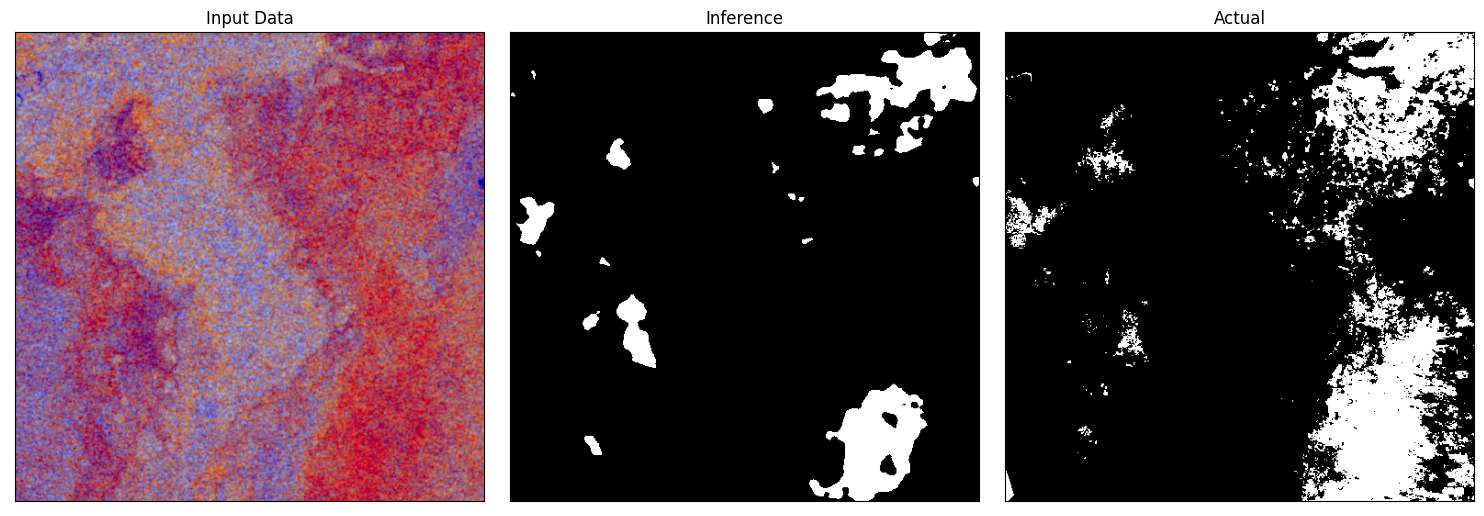

In [28]:
# DO NOT CHANGE THIS CELL
# visualize results
fig, ax_arr=plt.subplots(1, 3, figsize=[15, 5], sharex=True, sharey=True)
ax_arr[0].set_title('Input Data')
ax_arr[1].set_title('Inference')
ax_arr[2].set_title('Actual')
ax_arr[0].set_xticks([])
ax_arr[0].set_yticks([])

ax_arr[0].imshow(image)
ax_arr[1].imshow(np.argmax(logits, axis=3)[0]*255, cmap='gray')
ax_arr[2].imshow(mask, cmap='gray')

fig.tight_layout()
plt.show()

<p><img src='images/tip.png' width=720></p>

Recall that we used a random input image for demonstration. In case you don't get an image that shows presence of flood, please feel free to re-run the inference starting from [Exercise #2](#s3-e2). 

We can iterate through all input images to see how quickly Triton is able to perform inference. 

In [29]:
 # DO NOT CHANGE THIS CELL
time_list=[]

for image_path in os.listdir(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images')): 
    image=Image.open(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images', image_path))
    image_ary=preprocess_image(image)
    inference_input.set_data_from_numpy(image_ary)
    
    # time the process
    start=time.time()
    response=triton_client.infer(model_name, 
                                 model_version=model_version, 
                                 inputs=[inference_input], 
                                 outputs=[output])
    time_list.append(time.time()-start)
    logits=response.as_numpy(output_name)
    
latency=sum(time_list)/len(time_list)
print('It took {} seconds to infer {} images.'.format(round(sum(time_list), 3), len(time_list)))
print('On average it took {} seconds per inference.'.format(round(latency, 3)))

It took 11.606 seconds to infer 446 images.
On average it took 0.026 seconds per inference.


<a name='s3-4.4'></a>
### Run Batch Inference ###
One factor to consider for inference optimization is batch size, or how many samples you process at once. Below we're going to perform inference in batches. 

In [30]:
# DO NOT CHANGE THIS CELL
batch_size=8

In [31]:
# DO NOT CHANGE THIS CELL
# create directory for model
!mkdir -p models/flood_segmentation_model_batch/1

# copy sample_resnet18.engine to the model repository
!cp $LOCAL_EXPERIMENT_DIR/export/sample_resnet18.engine models/flood_segmentation_model_batch/1/model.plan

In [32]:
# DO NOT CHANGE THIS CELL
configuration = """
name: "flood_segmentation_model_batch"
platform: "tensorrt_plan"
max_batch_size: {}
input: [
 {{
    name: "input_1"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 512, 512 ]
 }}
]
output: {{
    name: "softmax_1"
    data_type: TYPE_FP32
    dims: [ 512, 512, 2]
 }}
""".format(batch_size)

with open('models/flood_segmentation_model_batch/config.pbtxt', 'w') as file:
    file.write(configuration)

In [33]:
# DO NOT CHANGE THIS CELL
# show model repository folder structure
!tree -a models

models
├── flood_segmentation_model
│   ├── 1
│   │   └── model.plan
│   └── config.pbtxt
└── flood_segmentation_model_batch
    ├── 1
    │   └── model.plan
    └── config.pbtxt

4 directories, 4 files


In [34]:
# DO NOT CHANGE THIS CELL
!sleep 45

In [35]:
# DO NOT CHANGE THIS CELL
!curl -v triton:8000/v2/models/flood_segmentation_model_batch

*   Trying 172.18.0.4:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.4) port 8000 (#0)
> GET /v2/models/flood_segmentation_model_batch HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Type: application/json
< Content-Length: 230
< 
* Connection #0 to host triton left intact
{"name":"flood_segmentation_model_batch","versions":["1"],"platform":"tensorrt_plan","inputs":[{"name":"input_1","datatype":"FP32","shape":[-1,3,512,512]}],"outputs":[{"name":"softmax_1","datatype":"FP32","shape":[-1,512,512,2]}]}

In [36]:
# DO NOT CHANGE THIS CELL
# define new input shape
batch_input_shape=(batch_size, 3, 512, 512)

batch_inference_input=tritonhttpclient.InferInput(name='input_1', shape=batch_input_shape, datatype='FP32')
batch_output=tritonhttpclient.InferRequestedOutput('softmax_1')

# create empty array for the batch input
batch_ary=np.empty(batch_input_shape).astype(np.float32)

time_list=[]

# iterate through all images
for idx, image_path in enumerate(os.listdir(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images'))): 
    image=Image.open(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images', image_path))
    batch_ary[idx%batch_size]=preprocess_image(image)
    if idx%batch_size==(batch_size-1): 
        batch_inference_input.set_data_from_numpy(batch_ary)

        # time the process
        start=time.time()
        response=triton_client.infer(model_name='flood_segmentation_model_batch', 
                                     model_version='1', 
                                     inputs=[batch_inference_input], 
                                     outputs=[batch_output])
        time_list.append(time.time()-start)
        logits=response.as_numpy(output_name)

batch_latency=sum(time_list)/len(time_list)
print('It took {} seconds to infer {} images.'.format(round(sum(time_list), 3), len(time_list)*batch_size))
print('On average it took {} seconds per inference.'.format(round(batch_latency, 3)))

It took 12.312 seconds to infer 440 images.
On average it took 0.224 seconds per inference.


<a name='s3-5'></a>
## Inference Performance Optimization ##
There is usually a trade-off between latency and throughput. Finding the right balance between them usually involves satisfying the application requirements. As an example, the Triton Inference Server can be connected to front-end applications such as those that power https://www.balcony.io/, which provides an emergency management platform. Amongst other services, it has the ability to send alerts to personal devices in real-time. NVIDIA's GPUs deliver high throughput at higher batch size. However, for real-time applications, the real constraint on services isn’t batch size or even throughput, but rather the latency required to deliver an outstanding experience for end users. You can read more about how Triton Inference Server is used to enable rapid disaster detection and response [here](https://siliconvalley.orange.com/en/news/rapid-disaster-detection-and-response-a-climate-action-collaboration/). 

In [ ]:
# DO NOT CHANGE THIS CELL
# plot throughput vs. latency
plt.title('Inference Performance Comparison')
plt.plot([latency, batch_latency], [1/latency, batch_size/batch_latency], marker='o')
plt.text(latency, (1/latency)-2.5, 'Non-Batching')
plt.text(batch_latency, (batch_size/batch_latency)-2.5, 'Batching ({})'.format(batch_size))

plt.xlabel('Latency (Second)')
plt.ylabel('Throughput (Image/Second)')
plt.xlim(xmin=0, xmax=max(batch_latency, latency)*1.25)
plt.ylim(ymin=0, ymax=max(1/latency, batch_size/batch_latency)*1.25)
plt.show()

**Well Done!** Let's move to the [next notebook](./04_unosat_flood_event_case_study.ipynb). 

<a href="https://www.nvidia.com/dli"> <img src="images/combined_logo.png" alt="Header" style="width: 400px;"/> </a>